# SETUP


In [1]:

import pandas as pd 
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import seaborn as sns
import matplotlib.pyplot as plt


user = "SA"
password = quote_plus("Megalochan1@1@")
server = 'localhost,1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\chn03\AppData\Local\Temp\ipykernel_2464\4245887741.py:26: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql_query(text(sql), conn)
    

# Visualisation 1 : Number of products per category
  ## How many products are there in each category?
  ## Tables used: Production.ProductCategory, Production.ProductSubcategory, Production.Product

There are four category of products: Components, Bikes, clothing and accessories. 
The category "Components" stands as the category with the highest number of products (134), followed by bikes (97), clothing (35) and lastly acessories (29). 

#
    

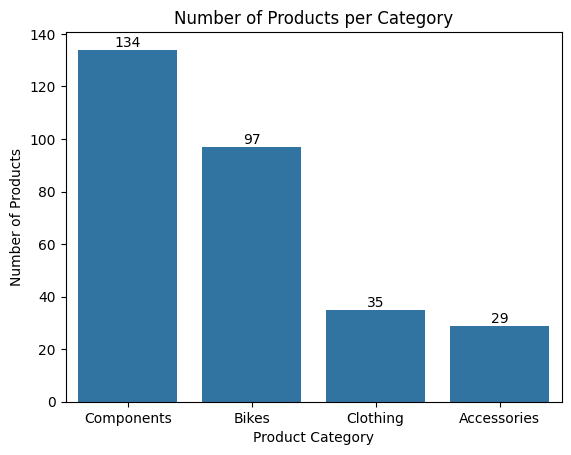

In [3]:
viz1= """
Select 
    PC.Name as CategoryName, 
    COUNT(DISTINCT P.ProductID) as ProductCount
From Production.ProductCategory as PC
Inner Join Production.ProductSubcategory as PS ON PC.ProductCategoryID = PS.ProductCategoryID  
Inner Join Production.Product as P ON PS.ProductSubcategoryID = P.ProductSubcategoryID
GROUP BY PC.Name
ORDER BY ProductCount DESC; 
"""


df_viz1 = query_df(viz1)
ax=sns.barplot(data=df_viz1, x='CategoryName', y='ProductCount')
ax.set_title('Number of Products per Category')
ax.set_xlabel('Product Category')
ax.set_ylabel('Number of Products')
ax.bar_label(ax.containers[0])
plt.show()

# Visualisation 2: Sales per category 
## What category produces the highest revenue?
## Tables used: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail


The bike category produces the highest revenue, followed by components, clothing and lastly accessories. With regards to the number of products sold, the accessories category produced the highest number of sales, followed by the bikes category, clothing and lastly the components category. 

In plotting the graph for total sales amount per category, i plotted two graphs: one using the LinteTotal, a variable in the data that represents the sales revenue for each order and the TotalSales, a computed variables from the quantity sold and the unit price. Both plotes produced the simialr conclusion. 

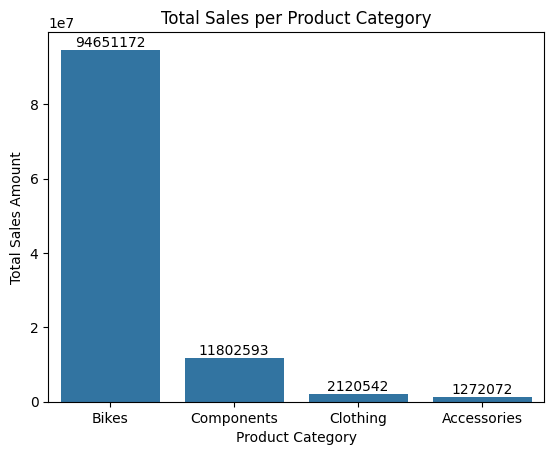

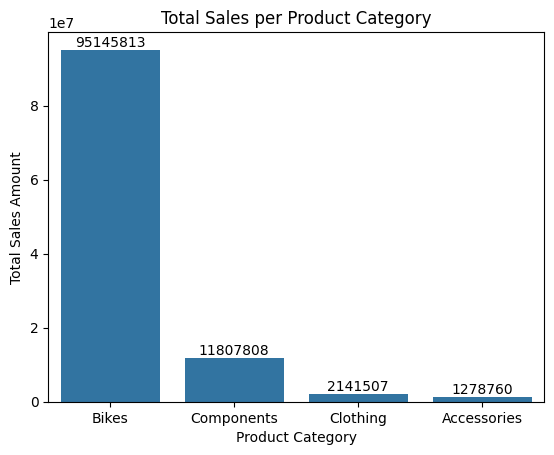

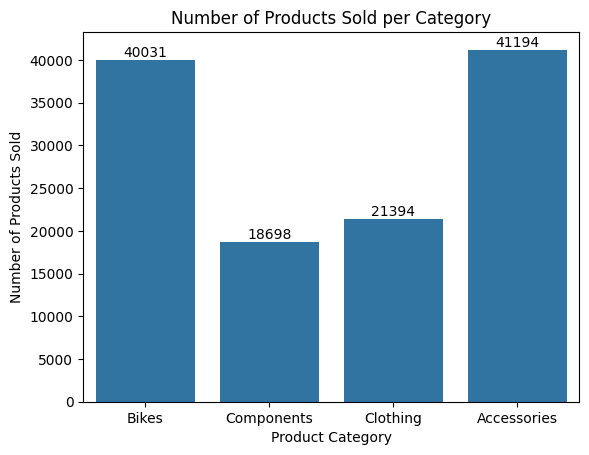

In [ ]:
viz2= """
SELECT 
    PC.Name AS CategoryName, 
    COUNT(SOD.OrderQty) AS NumberOfProductsSold,
    SUM(SOD.LineTotal) AS LineTotal,
    SUM(SOD.OrderQty * SOD.UnitPrice) AS TotalSales --verifying this figure with thr LineTotal
FROM Production.ProductCategory AS PC 
INNER JOIN Production.ProductSubcategory AS PS ON PC.ProductCategoryID = PS.ProductCategoryID  
INNER JOIN Production.Product AS P ON PS.ProductSubcategoryID = P.ProductSubcategoryID
INNER JOIN sales.SalesOrderDetail AS SOD ON P.ProductID = SOD.ProductID
GROUP BY PC.Name   
ORDER BY  SUM(SOD.OrderQty * SOD.UnitPrice) DESC, NumberOfProductsSold DESC ;
"""
df_viz2 = query_df(viz2)

ax=sns.barplot(data=df_viz2, x='CategoryName', y='LineTotal')
ax.set_title('Total Sales per Product Category')
ax.set_xlabel('Product Category')
ax.set_ylabel('Total Sales Amount')
ax.bar_label(ax.containers[0], fmt='%d')
plt.show()

ax=sns.barplot(data=df_viz2, x='CategoryName', y='TotalSales')
ax.set_title('Total Sales per Product Category')
ax.set_xlabel('Product Category')
ax.set_ylabel('Total Sales Amount')
ax.bar_label(ax.containers[0], fmt='%d')
plt.show()

ax=sns.barplot(data=df_viz2, x='CategoryName', y='NumberOfProductsSold')
ax.set_title('Number of Products Sold per Category')
ax.set_xlabel('Product Category')
ax.set_ylabel('Number of Products Sold')
ax.bar_label(ax.containers[0], fmt='%d')
plt.show()

# Visualisation 3: Sales trend over time
## How has sales developed over time?
## Table used: Sales.SalesOrderHeader


Total revenue from sales varied significantly over the months from May 2022 to June 2025. The total revenue increased from 2022 to 2025. Though we observed a significant drop in income between some of the months within the time frame, the total sales did not fall below the total sales from the initial month, except for June 2025.

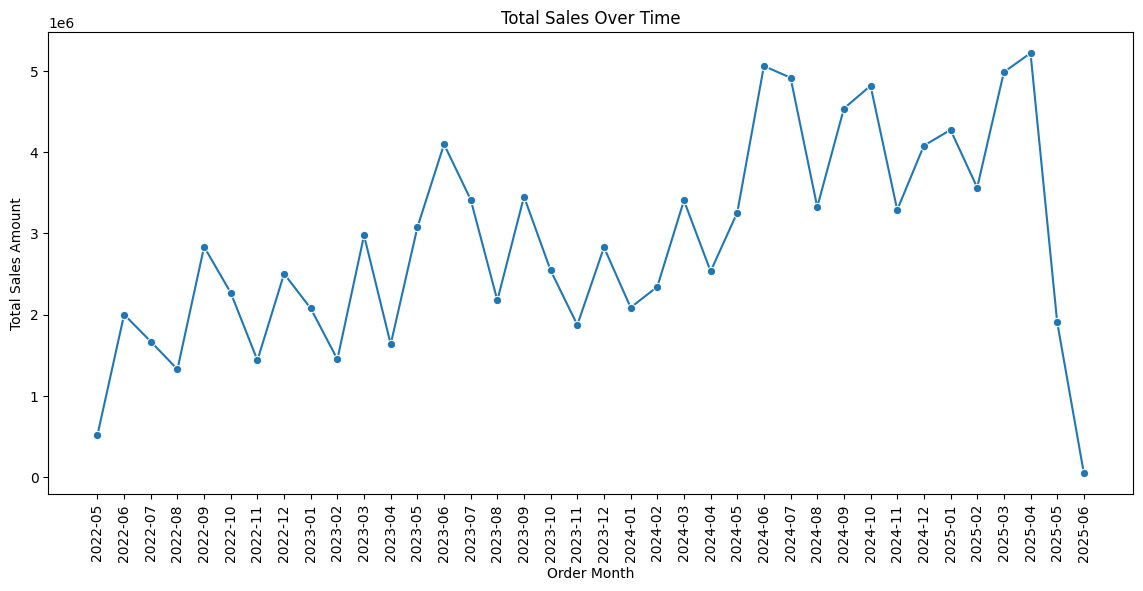

In [5]:
viz3= """
SELECT
FORMAT(SOD.OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(SOD.SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader AS SOD
GROUP BY
    FORMAT(SOD.OrderDate, 'yyyy-MM')        
ORDER BY
    OrderMonth;
"""
df_viz3 = query_df(viz3)
plt.figure(figsize=(14, 6))
ax=sns.lineplot(data=df_viz3, x='OrderMonth', y='TotalSales', marker='o')
ax.set_title('Total Sales Over Time')   
ax.set_xlabel('Order Month')
ax.set_ylabel('Total Sales Amount')
plt.xticks(rotation=90)
plt.show()



# Visualisation 4: Sales and total order per year 
## Hur ser total försäljning och antal ordrar ut per år?
## Tables used: Sales.SalesOrderHeader


The total number of orders and total sales amount increased steadily from 2022 to 2024 and then droped slightly to 2025. Upon further investigations, we observed the same trend accross the different territories. Furthermore, sales category 4 "Southwest" produced the highest sales in each year. 

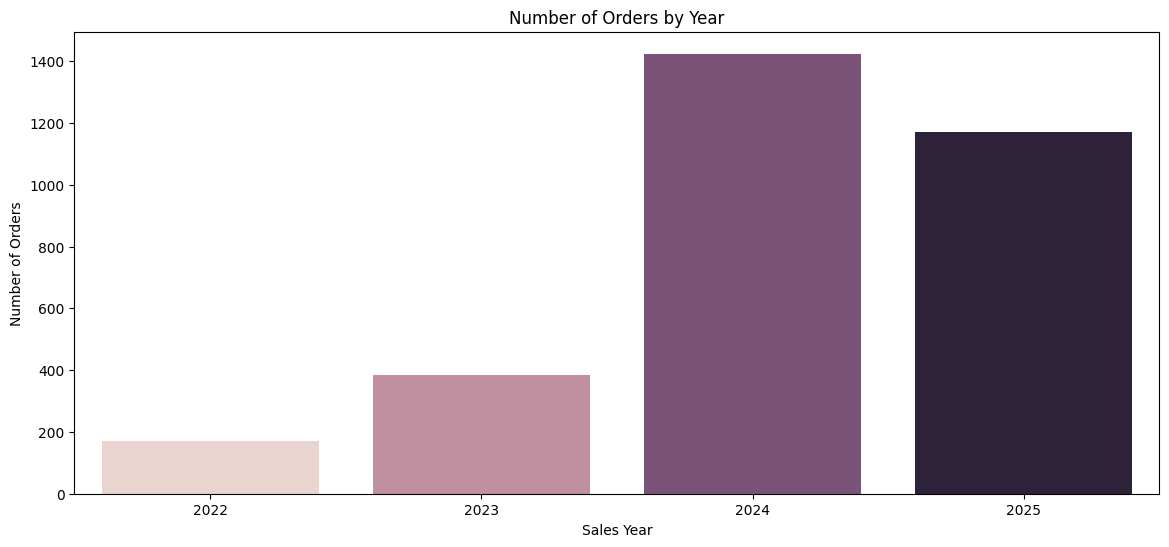

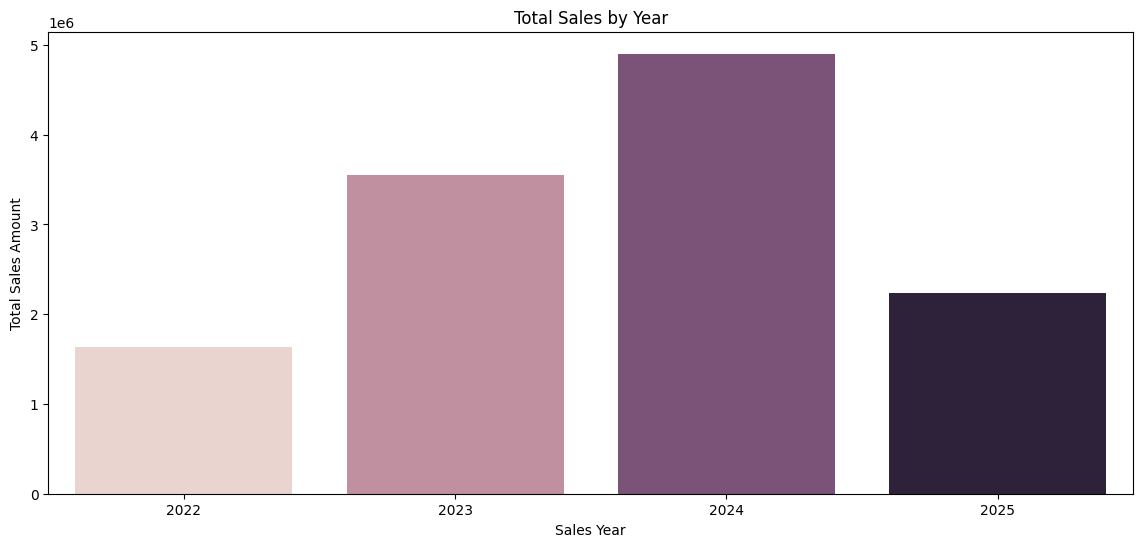

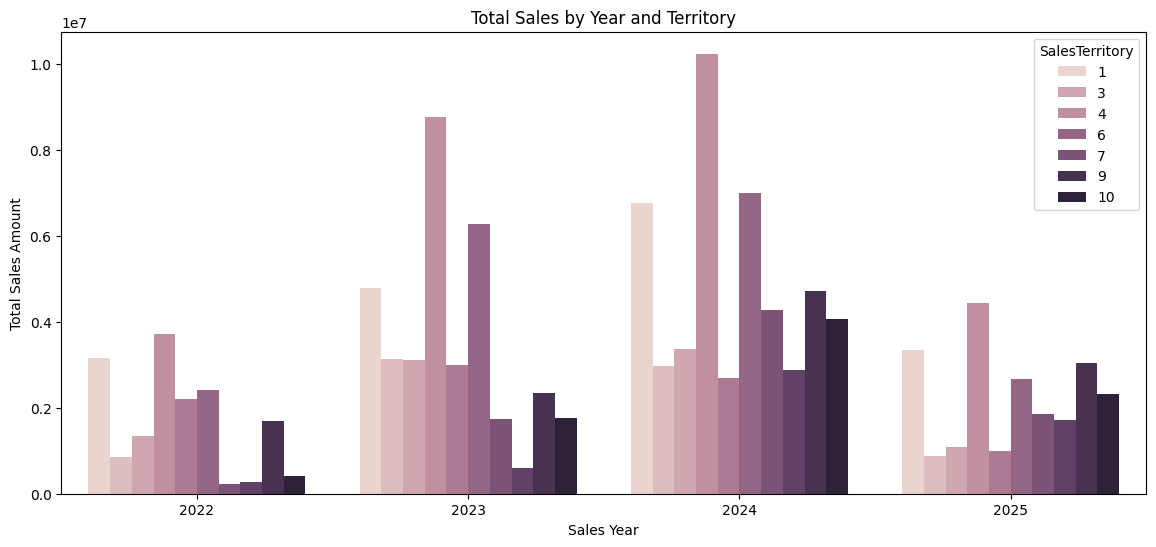

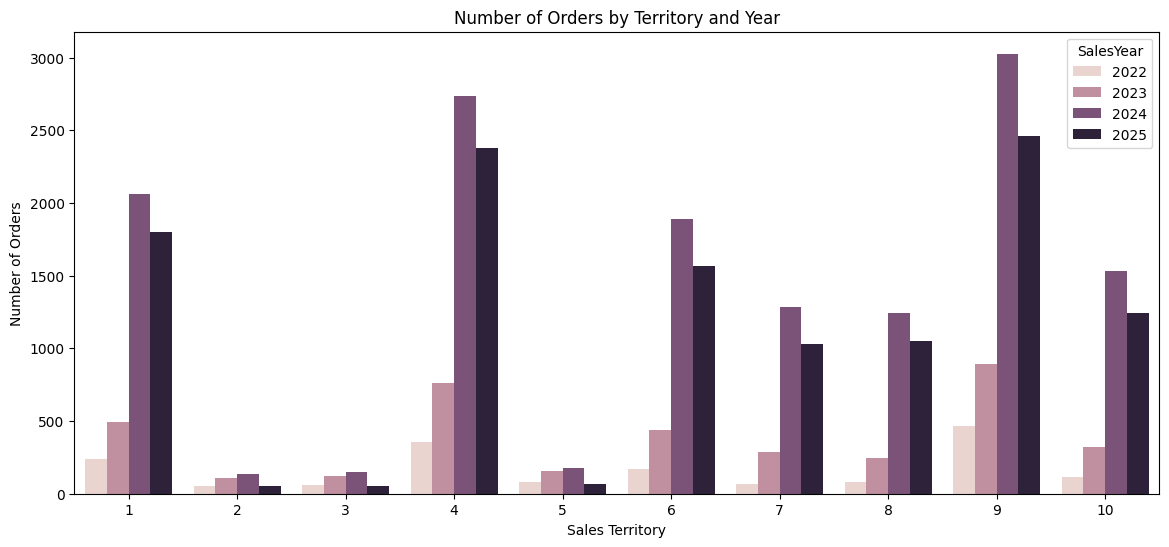

In [18]:
viz4= """
SELECT 
    
    COUNT(DISTINCT SalesOrderID) AS OrderCount,
    TerritoryID AS SalesTerritory,
    SUM(TotalDue) as TotalSales,
    YEAR(OrderDate) as SalesYear
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), TerritoryID
ORDER BY SalesYear DESC, TotalSales DESC;
""" 
    
df_viz4 = query_df(viz4)


plt.figure(figsize=(14, 6))
ax= sns.barplot(data=df_viz4, x='SalesYear', y='OrderCount', errorbar=None, hue='SalesYear', legend=False)
ax.set_title('Number of Orders by Year')
ax.set_xlabel('Sales Year')
ax.set_ylabel('Number of Orders')


plt.figure(figsize=(14, 6))
ax= sns.barplot(data=df_viz4, x='SalesYear', y='TotalSales', errorbar=None, hue='SalesYear', legend=False)
ax.set_title('Total Sales by Year')
ax.set_xlabel('Sales Year')
ax.set_ylabel('Total Sales Amount')


plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz4, x='SalesYear', y='TotalSales', hue='SalesTerritory')
ax.set_title('Total Sales by Year and Territory')
ax.set_xlabel('Sales Year')
ax.set_ylabel('Total Sales Amount')

plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz4, x='SalesTerritory', y='OrderCount', hue='SalesYear')
ax.set_title('Number of Orders by Territory and Year')
ax.set_xlabel('Sales Territory')
ax.set_ylabel('Number of Orders')


plt.show()

# Visualisation 5: Top 10 products
## Vilka 10 produkter genererar mest försäljning?
## Tables used: Production.Product and  Sales.SalesOrderDetail

The Touring-1000 Yellow, 46 bike produced the highest sales amount among the top 10 products while Road-350-W Yellow, 48 produced the lowest sales among the top 10 products.



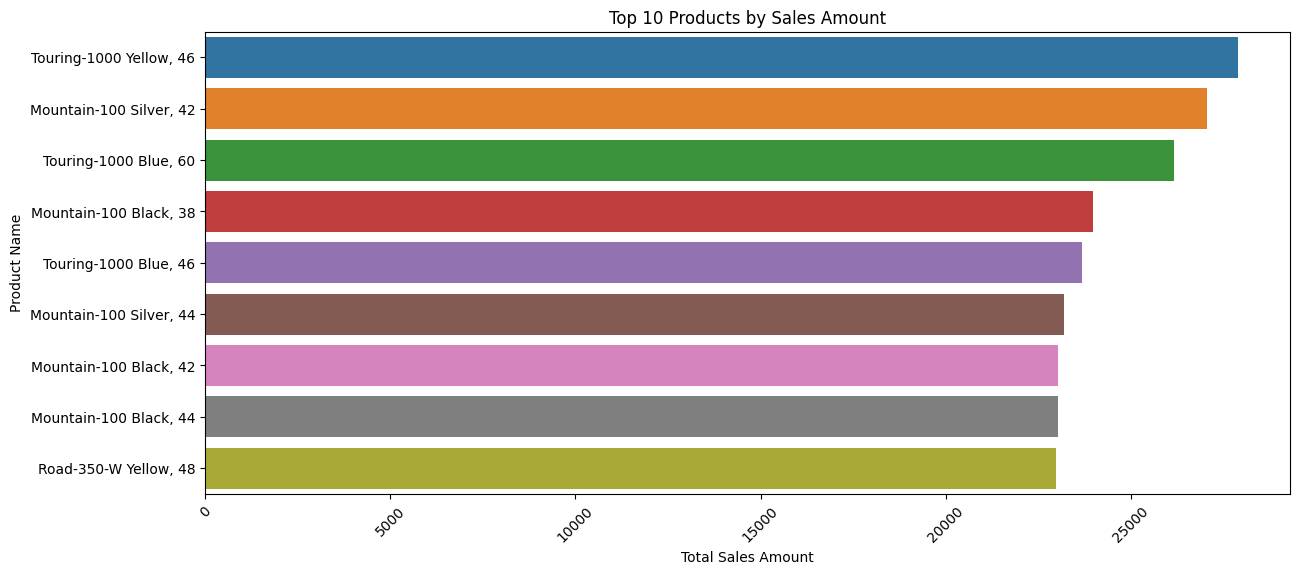

In [20]:
viz5= """
SELECT 
Distinct TOP 10 P.Name as ProductName,
SOD.LineTotal as TotalSales
FROM Sales.SalesOrderDetail SOD
JOIN Production.Product P
ON SOD.ProductID = P.ProductID
ORDER BY TotalSales DESC; 
""" 
df_viz5 = query_df(viz5)
plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz5, x='TotalSales', y='ProductName', errorbar=None, hue='ProductName', legend=False)
ax.set_title('Top 10 Products by Sales Amount') 
ax.set_xlabel('Total Sales Amount')
ax.set_ylabel('Product Name')
plt.xticks(rotation=45)
plt.show()

# Visualisation 6:Sales and number of customers per region
## How do sales differ between different regions, and how many unique customers does each region have?
## Tables used : Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

The highest total sales amount were recorded in North America, followed by the pacific and finally in Europe. However, interms of total number of customers, The pacific had the highest number of customers, followed by North America. Further investigations reveal that the highest three sales were realised from North America, followed by Australia and the lowest sales amount was realised in Germany. 


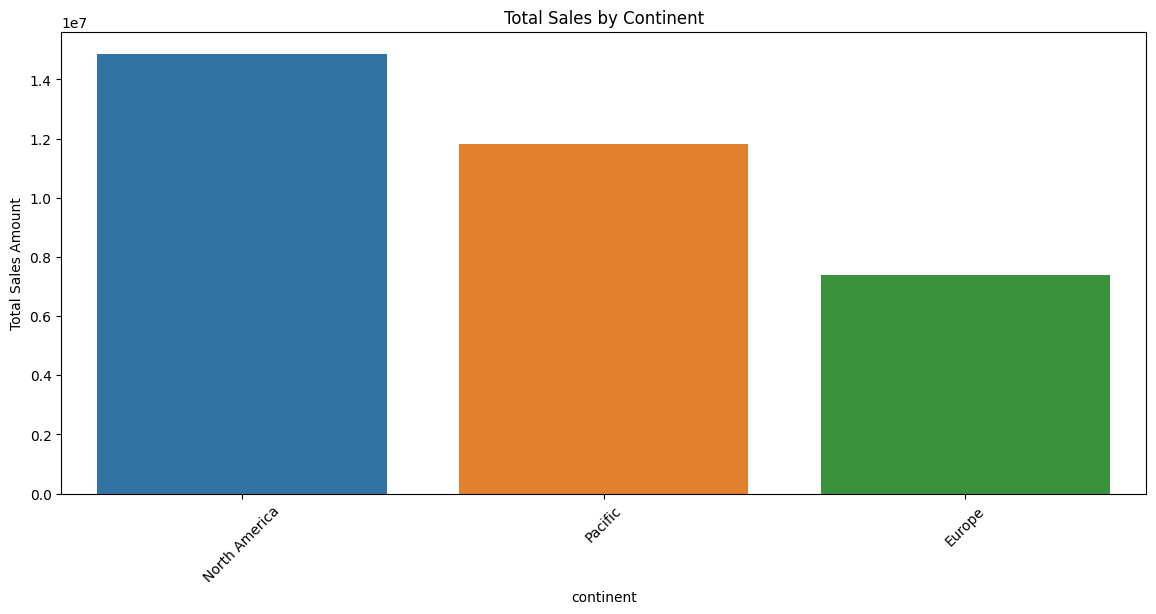

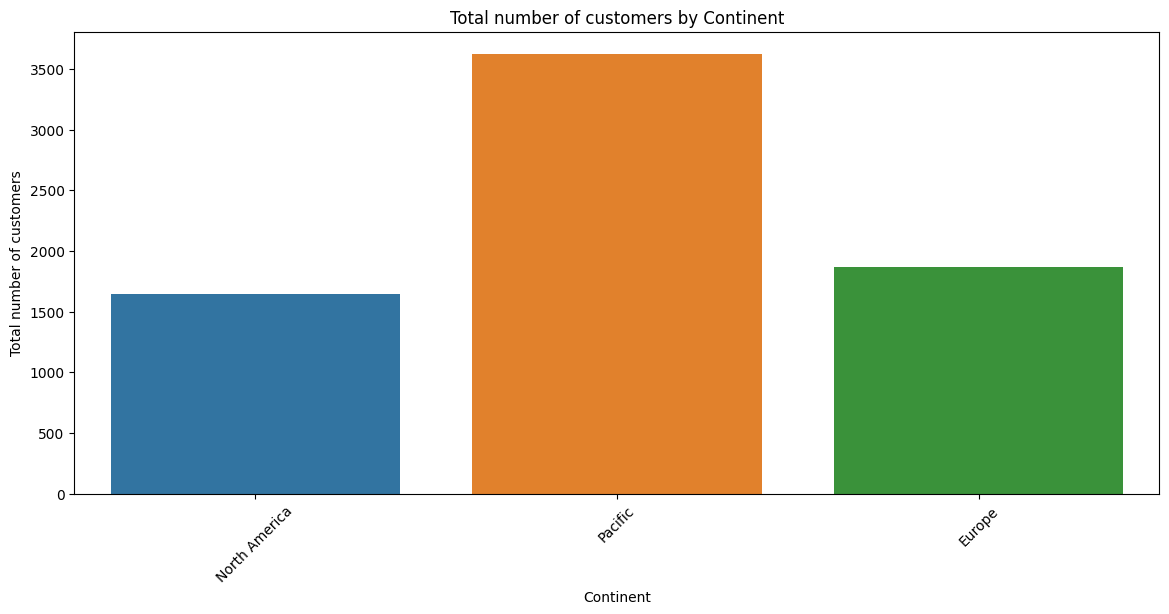

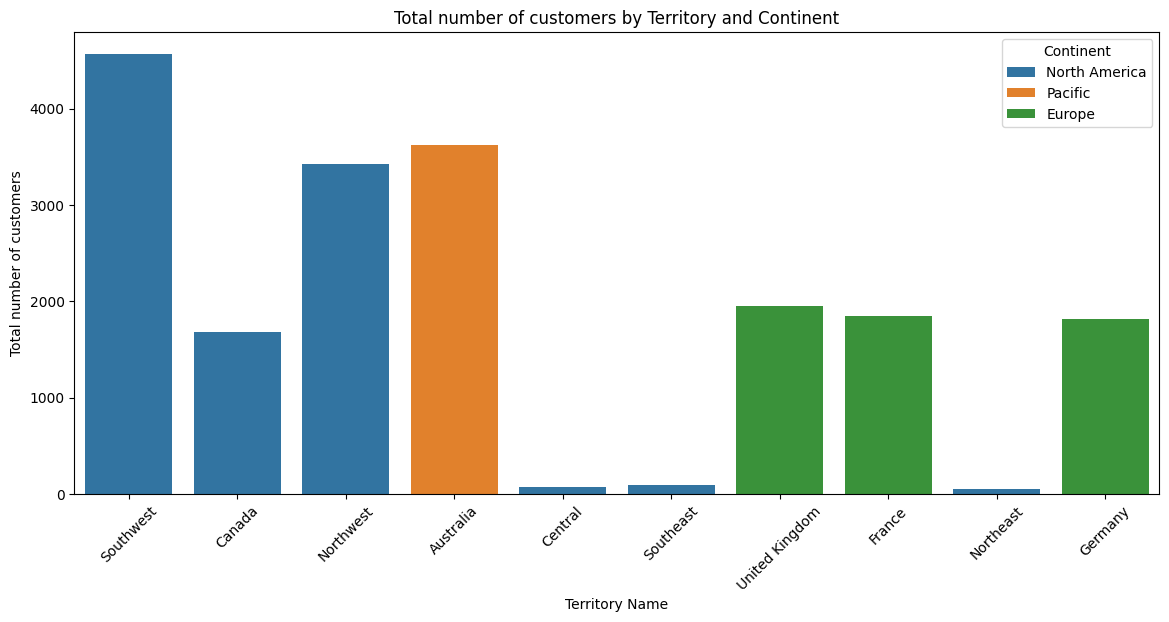

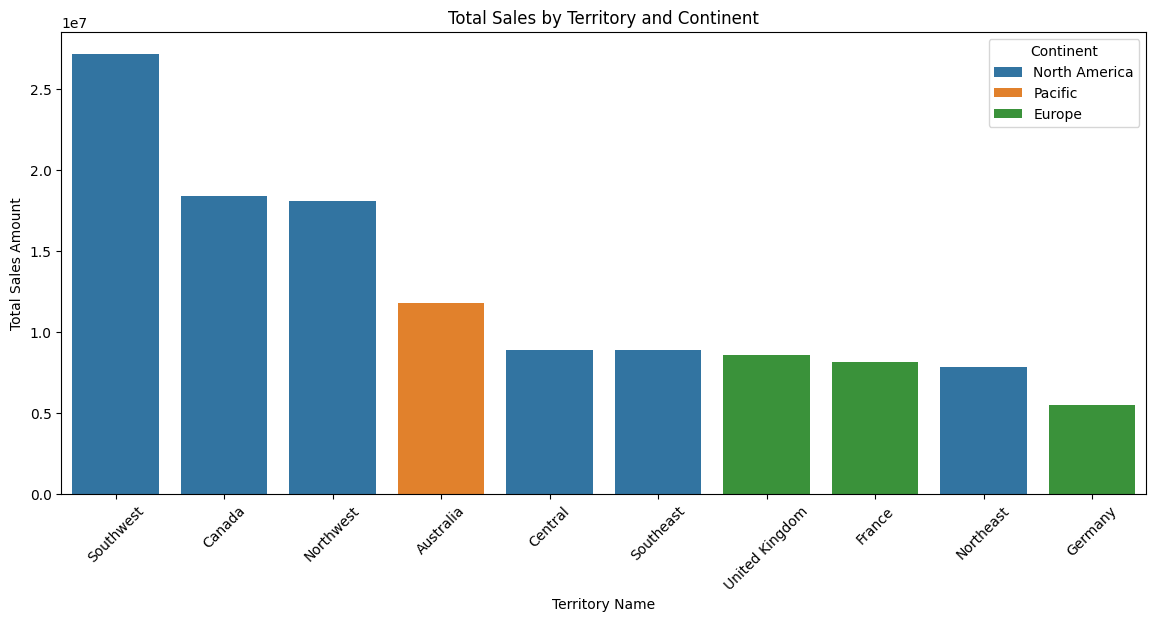

In [23]:
viz6= """
SELECT
    TERR.Name AS TerritoryName,   
    COUNT(DISTINCT CUST.CustomerID) AS CustomerCount,
    SUM(SOH.TotalDue) AS TotalSales,
    TERR.[Group] AS Continent
FROM Sales.SalesOrderHeader AS SOH
JOIN Sales.Customer AS CUST
ON SOH.CustomerID = CUST.CustomerID
JOIN Sales.SalesTerritory AS TERR
ON CUST.TerritoryID = TERR.TerritoryID
GROUP BY TERR.Name, TERR.[Group]
ORDER BY TotalSales DESC, CustomerCount DESC;
"""
df_viz6 = query_df(viz6)
plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz6, x='Continent', y='TotalSales', hue='Continent', legend=False, errorbar=None)
ax.set_title('Total Sales by Continent')  
ax.set_xlabel('continent')
ax.set_ylabel('Total Sales Amount')
plt.xticks(rotation=45)

plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz6, x='Continent', y='CustomerCount', hue='Continent', errorbar=None)
ax.set_title('Total number of customers by Continent')  
ax.set_xlabel('Continent')
ax.set_ylabel('Total number of customers')
plt.xticks(rotation=45)

plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz6, x='TerritoryName', y='CustomerCount', hue='Continent', errorbar=None)
ax.set_title('Total number of customers by Territory and Continent')  
ax.set_xlabel('Territory Name')
ax.set_ylabel('Total number of customers')
plt.xticks(rotation=45)


plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz6, x='TerritoryName', y='TotalSales', hue='Continent', errorbar=None)
ax.set_title('Total Sales by Territory and Continent')  
ax.set_xlabel('Territory Name')
ax.set_ylabel('Total Sales Amount')
plt.xticks(rotation=45)


plt.show()

# Visualisation 7: Average order value by region and customer type
## Which regions have the highest/lowest average order value, and does it differ between individual customers and corporate customers?
## Tables used : Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer, Sales.Store

The total sales amount was higher for corperate customers (Stores), compared to individual customers in North america and Europe. However, in the pacific, Individual customers produced the highest sales amount.
Considering the average order value, Coperate customers (stores), produced the highest sales amount compared to individual customers accross all continents. 

Further investigations of total sales amount by indivual territories, corperate customers produced the highest sales amount accros all regions except for Germany and Australia where individual customers produced the highest sales amount. Furthermore the Central, South East and North East regions of North America had only corperate customers, compared to other individual regions that had both corperate and individual customers. 


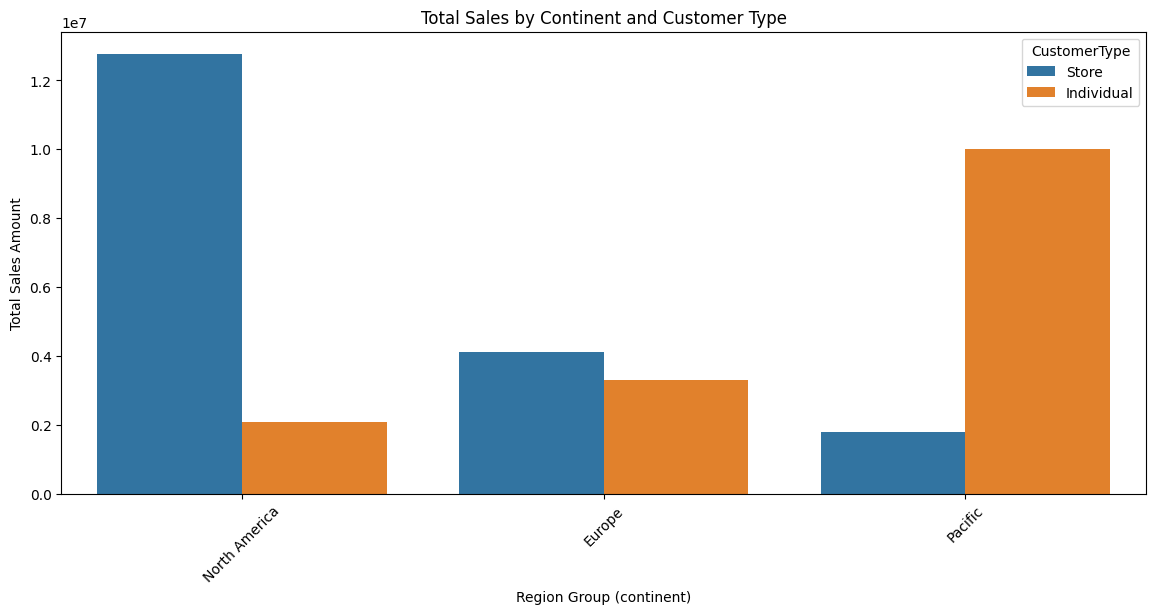

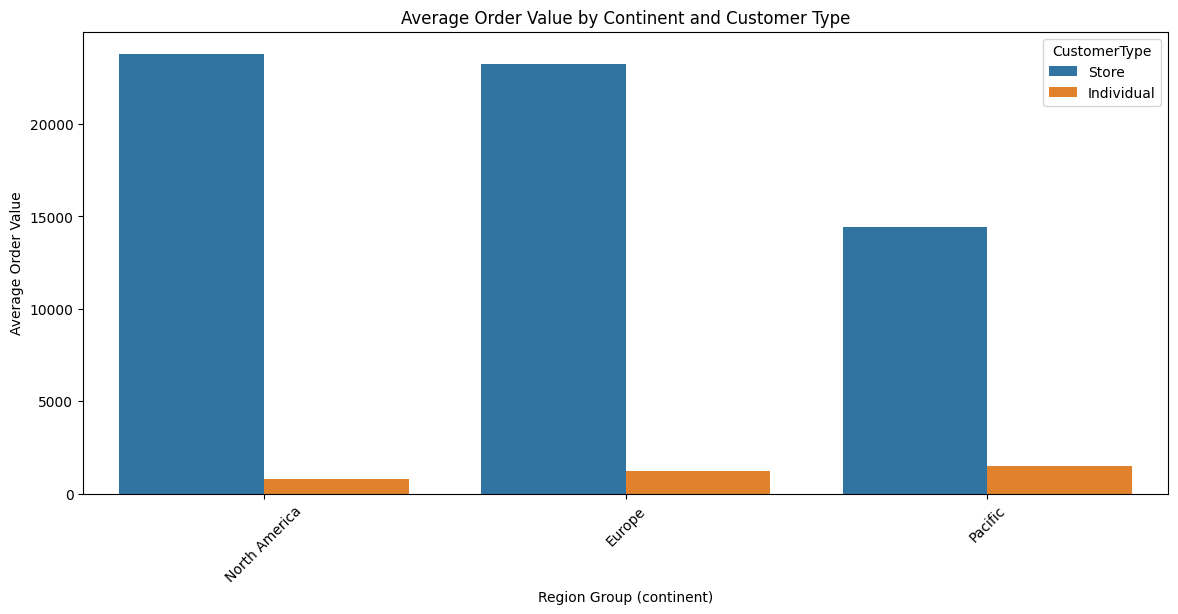

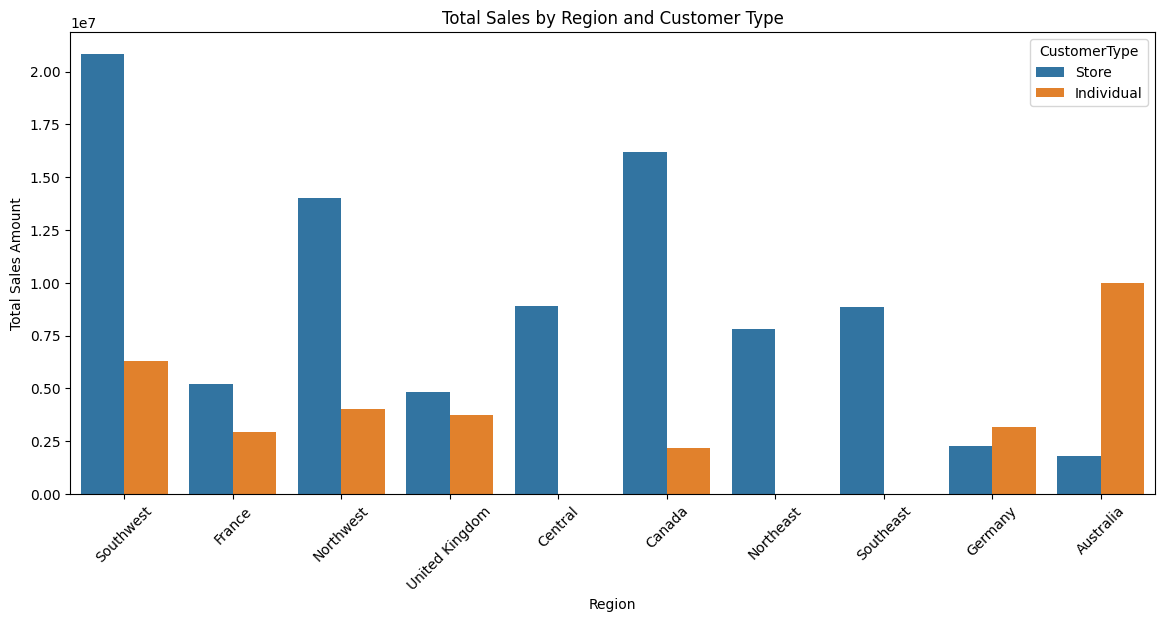

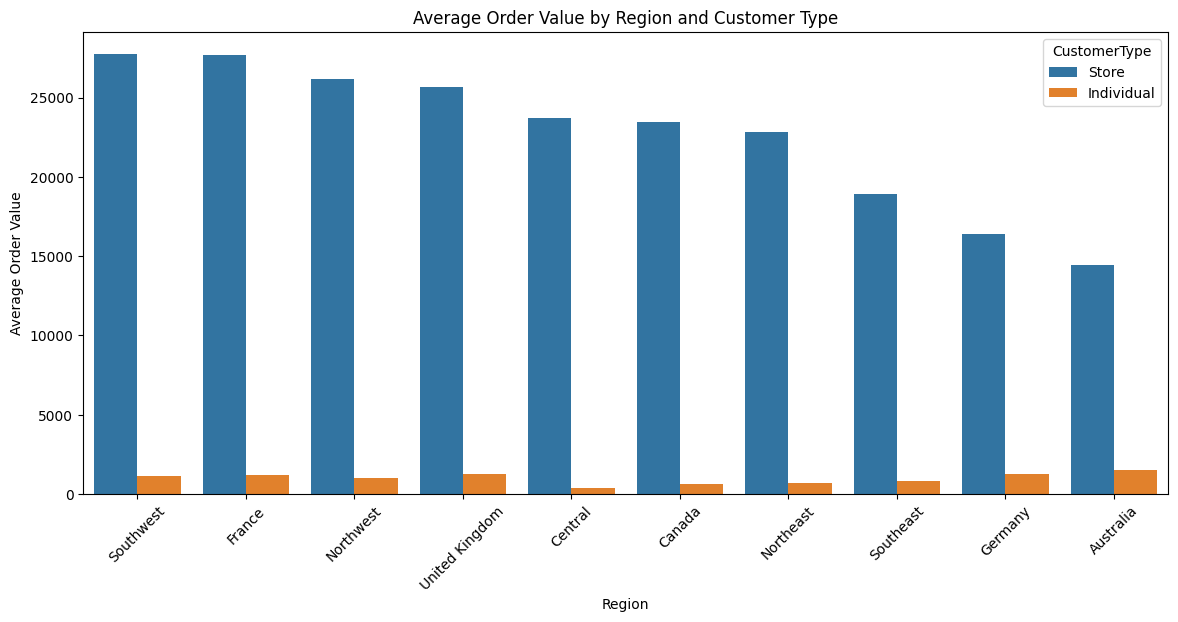

In [24]:
viz7= """
SELECT
    st.Name AS Region,
    st.[Group] AS RegionGroup,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        WHEN c.PersonID IS NOT NULL THEN 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.SalesOrderID) AS OrderCount,
    SUM(TotalDue)/COUNT(DISTINCT SalesOrderID) AS AvgOrderValue
FROM Sales.SalesOrderHeader AS soh
JOIN Sales.Customer AS c ON soh.CustomerID = c.CustomerID
JOIN Sales.SalesTerritory AS st ON c.TerritoryID = st.TerritoryID
GROUP BY st.Name,
         CASE 
             WHEN c.StoreID IS NOT NULL THEN 'Store'
             WHEN c.PersonID IS NOT NULL THEN 'Individual'
         END, st.[Group]
ORDER BY AVG(soh.TotalDue) DESC;

"""
df_viz7 = query_df(viz7)


plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz7, x='RegionGroup', y='TotalSales', hue='CustomerType', errorbar=None)
ax.set_title('Total Sales by Continent and Customer Type') 
ax.set_xlabel('Region Group (continent)')
ax.set_ylabel('Total Sales Amount')
plt.xticks(rotation=45)


plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz7, x='RegionGroup', y='AvgOrderValue', hue='CustomerType', errorbar=None)
ax.set_title('Average Order Value by Continent and Customer Type')
ax.set_xlabel('Region Group (continent)')
ax.set_ylabel('Average Order Value')
plt.xticks(rotation=45)

plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz7, x='Region', y='TotalSales', hue='CustomerType', errorbar=None)
ax.set_title('Total Sales by Region and Customer Type') 
ax.set_xlabel('Region')
ax.set_ylabel('Total Sales Amount')
plt.xticks(rotation=45)


plt.figure(figsize=(14, 6))
ax=sns.barplot(data=df_viz7, x='Region', y='AvgOrderValue', hue='CustomerType', errorbar=None)
ax.set_title('Average Order Value by Region and Customer Type')
ax.set_xlabel('Region')
ax.set_ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.show()

